**POZOR: Tento notebook je potrebné spustiť v Google Colab notebooku.**

# Generovanie ľudských tvári pomocou StyleGAN

V notebook-u predvedieme, ako sa dajú generovať obrázky ľudských tvárí pomocou metódy StyleGAN z článku ["A Style-Based Generator Architecture for Generative Adversarial Networks"](https://arxiv.org/abs/1812.04948) od firmy NVIDIA. Oficiálna implementácia metódy sa dá nájsť v [GitHub repozitári](https://github.com/NVlabs/stylegan). Okrem toho používame latentné vektory a časť kódu z [ďalšieho GitHub repozitára](https://github.com/Puzer/stylegan-encoder.git).

## Stiahnutie kódu a načítanie modelu

Na začiatku si stiahneme repozitár s oficiálnou implementáciou.

In [0]:
!git clone https://github.com/Puzer/stylegan-encoder.git

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 105, done.
remote: Total 105 (delta 0), reused 0 (delta 0), pack-reused 105
Receiving objects: 100% (105/105), 10.38 MiB | 25.44 MiB/s, done.
Resolving deltas: 100% (28/28), done.


Importujeme potrebné balíčky.

In [0]:
import sys
sys.path.append('stylegan-encoder')

import os
import bz2
import dlib
import PIL.Image
import numpy as np
from keras.utils import get_file
import matplotlib.pyplot as plt
from google.colab import files

import pickle
import config
import dnnlib
import dnnlib.tflib as tflib

from tqdm.autonotebook import tqdm
import tensorflow as tf
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
import keras.backend as K

from keras.applications.vgg16 import VGG16, preprocess_input
from scipy.optimize import fmin_l_bfgs_b
import scipy

In [0]:
#@title >> SKRYTÁ IMPLEMENTÁCIA RUTÍN << { display-mode: "form" }

def unpack_bz2(src_path):
    data = bz2.BZ2File(src_path).read()
    dst_path = src_path[:-4]
    with open(dst_path, 'wb') as fp:
        fp.write(data)
    return dst_path
  
def image_align(img, face_landmarks, output_size=1024, transform_size=4096, enable_padding=True):
    # Align function from FFHQ dataset pre-processing step
    # https://github.com/NVlabs/ffhq-dataset/blob/master/download_ffhq.py

    lm = np.array(face_landmarks)
    lm_chin          = lm[0  : 17]  # left-right
    lm_eyebrow_left  = lm[17 : 22]  # left-right
    lm_eyebrow_right = lm[22 : 27]  # left-right
    lm_nose          = lm[27 : 31]  # top-down
    lm_nostrils      = lm[31 : 36]  # top-down
    lm_eye_left      = lm[36 : 42]  # left-clockwise
    lm_eye_right     = lm[42 : 48]  # left-clockwise
    lm_mouth_outer   = lm[48 : 60]  # left-clockwise
    lm_mouth_inner   = lm[60 : 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left     = np.mean(lm_eye_left, axis=0)
    eye_right    = np.mean(lm_eye_right, axis=0)
    eye_avg      = (eye_left + eye_right) * 0.5
    eye_to_eye   = eye_right - eye_left
    mouth_left   = lm_mouth_outer[0]
    mouth_right  = lm_mouth_outer[6]
    mouth_avg    = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        dst_img = img.resize(rsize, PIL.Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink
    else:
        dst_img = img.copy()

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))),
            int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    crop = (max(crop[0] - border, 0),
            max(crop[1] - border, 0),
            min(crop[2] + border, dst_img.size[0]),
            min(crop[3] + border, dst_img.size[1]))
    if crop[2] - crop[0] < dst_img.size[0] or crop[3] - crop[1] < dst_img.size[1]:
        dst_img = dst_img.crop(crop)
        quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - dst_img.size[0] + border, 0), max(pad[3] - dst_img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        dst_img = np.pad(np.float32(dst_img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = dst_img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
        blur = qsize * 0.02
        dst_img += (scipy.ndimage.gaussian_filter(dst_img, [blur, blur, 0]) - dst_img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        dst_img += (np.median(dst_img, axis=(0,1)) - dst_img) * np.clip(mask, 0.0, 1.0)
        dst_img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(dst_img), 0, 255)), 'RGB')
        quad += pad[:2]

    # Transform.
    dst_img = dst_img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    if output_size < transform_size:
        dst_img = dst_img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

    return dst_img
  
class LandmarksDetector:
    def __init__(self, predictor_model_path):
        """
        :param predictor_model_path: path to shape_predictor_68_face_landmarks.dat file
        """
        self.detector = dlib.get_frontal_face_detector() # cnn_face_detection_model_v1 also can be used
        self.shape_predictor = dlib.shape_predictor(predictor_model_path)

    def get_landmarks(self, img):
        dets = self.detector(img, 1)

        for detection in dets:
            face_landmarks = [(item.x, item.y) for item in self.shape_predictor(img, detection).parts()]
            yield face_landmarks
            
def convert_images_loss(images):
    drange=[-1,1]
    nchw_to_nhwc=True
    shrink=1
    
    images = tf.cast(images, tf.float32)
    if shrink > 1:
        ksize = [1, 1, shrink, shrink]
        images = tf.nn.avg_pool(images, ksize=ksize, strides=ksize, padding="VALID", data_format="NCHW")
    if nchw_to_nhwc:
        images = tf.transpose(images, [0, 2, 3, 1])
    scale = 255 / (drange[1] - drange[0])
    images = images * scale + (0.5 - drange[0] * scale)
    
    return images
  
def convert_images_gen(images):
    images = tf.saturate_cast(images, tf.uint8)
    return images
  
class Evaluator(object):
    def __init__(self, aligned_img, loss_grad_func, latent_shape):
        self.loss_value = None
        self.grads_values = None
        self.latent_shape = latent_shape
        
        aligned_img = np.asarray(aligned_img)
        if len(aligned_img.shape) == 4:
            self.aligned_img = aligned_img
        elif len(aligned_img.shape) == 3:
            self.aligned_img = np.expand_dims(aligned_img, 0)
        else:
            raise RuntimeError("Unsupported image shape '{}'.".format(aligned_img.shape))

        self.loss_grad_func = loss_grad_func
        
        self.eval_iter = 0

    def loss(self, latent):
        assert self.loss_value is None
        latent = latent.reshape(self.latent_shape) 
        outs = self.loss_grad_func([self.aligned_img, latent])
        self.loss_value = outs[0]
        self.grad_values = np.array(outs[1:]).flatten().astype('float64')
        
        # clip the gradients
        self.grad_values = np.maximum(np.minimum(self.grad_values, 1.0), -1.0)

        self.eval_iter += 1
        print("eval {}, loss {}".format(self.eval_iter, self.loss_value))
        
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

def move_and_show(dlatent, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(12, 10), dpi=80)
    dlatent = dlatent.reshape(dlatent_shape)
    
    for i, coeff in enumerate(coeffs):
        new_latent_vector = dlatent.copy()
        new_latent_vector[:8] = (dlatent + coeff*direction)[:8]
        ax[i].imshow(gen_func([new_latent_vector])[0][0])
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()
    
def blend_and_show(dlatent1, dlatent2, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(12, 10), dpi=80)
    dlatent1 = dlatent1.reshape(dlatent_shape)
    
    for i, coeff in enumerate(coeffs):
        new_latent_vector = coeff * dlatent1 + (1-coeff) * dlatent2
        ax[i].imshow(gen_func([new_latent_vector])[0][0])
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()

## Definícia parametrov a načítanie modelov

Definujeme niekoľko základných parametrov.

In [0]:
URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'
LANDMARKS_MODEL_URL = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'

batch_size = 1
feature_img_size = 256
aligned_img_size = 1024
vgg_layer = 9

Načítame predtrénované modely – GAN siete na generovanie obrázkov.

In [0]:
tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

Instructions for updating:
Colocations handled automatically by placer.


Modely, ktorými sa zarovnajú tváre.

In [0]:
landmarks_model_path = unpack_bz2(
    get_file('shape_predictor_68_face_landmarks.dat.bz2',
    LANDMARKS_MODEL_URL, cache_subdir='temp')
)

landmarks_detector = LandmarksDetector(landmarks_model_path)

Časti modelu, ktoré sa pri generovaní tvárí používajú, si oddelíme a vytvoríme funkcie, ktoré ich umožnia použiť. Časť, ktorá mapuje pôvodný latentný vektor na štýlový latentný vektor:

In [0]:
tf_map_in = Gs_network.components.mapping.input_templates[0]
tf_map_out = Gs_network.components.mapping.output_templates[0]
map_func = K.function([tf_map_in], [tf_map_out])

Časť, ktorá zo štýlového latentného vektora generuje obrázky:

In [0]:
tf_dlatents = Gs_network.components.synthesis.input_templates[0]
tf_output = Gs_network.components.synthesis.output_templates[0]
tf_loss_img_out = convert_images_loss(tf_output)
tf_img_out = convert_images_gen(tf_loss_img_out)
gen_func = K.function([tf_dlatents], [tf_img_out])

Tvar latentného a štýlového latentného vektora si uložíme do pomocných premenných.

In [0]:
latent_shape = (1,) + K.int_shape(tf_map_in)[1:]
dlatent_shape = (1,) + K.int_shape(tf_dlatents)[1:]

## Generovanie náhodných tvárí

Ďalej si vygenerujeme náhodnú tvár. Začneme vygenerovaním latentného vektora. Jeho prvky budeme brať z normálneho rozdelenia a jeho tvar bude podľa premennej ``latent_shape``.

In [0]:
latents = np.random.randn(*latent_shape)

Štýlový latentný vektor získame tak, že na ten pôvodný aplikujeme funkciu ``map_func``, ktorú sme vyššie definovali.

In [0]:
dlatents = map_func([latents])[0]

Ďalej môžeme ``dlatents`` použiť ako vstup pre funkciu ``gen_func``, ktorá vygeneruje samotný obrázok.

In [0]:
img = gen_func([dlatents])[0][0]

Potom nezostáva už nič iné než si obrázok vizualizovať, prípadne uložiť do súboru.

(-0.5, 1023.5, 1023.5, -0.5)

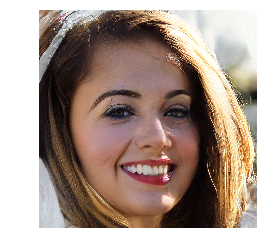

In [0]:
plt.imshow(img)
plt.axis('off')

Generovanie ďalších obrázkov si môžeme vyskúšať tu – stačí zakaždým vygenerovať iný latentný vektor.

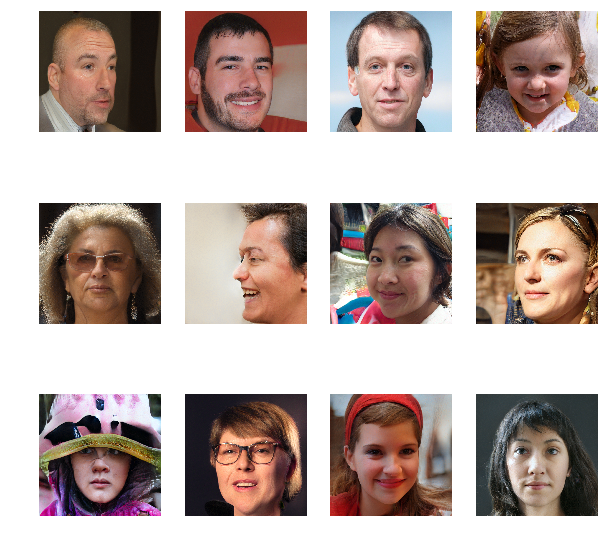

In [0]:
fig, axes = plt.subplots(3, 4, figsize=(10, 10))

for row in axes:
    for ax in row:
        latents = np.random.randn(*latent_shape)
        dlatents = map_func([latents])[0]
        img = gen_func([dlatents])[0][0]
        ax.imshow(img)
        ax.axis('off')

## Štýlový latentný vektor existujúcej tváre

GAN sieť by sa dala použiť aj na zaujímavé manipulácie s existujúcimi tvárami. Potrebovali by sme však najprv poznať latentné vektory, ktoré im zodpovedajú. StyleGAN však funguje len jednosmerne: generuje tváre z latentných vektorov, nie naopak.

Vieme však využiť obdobný princíp, aký používame pri generovaní predobrazov a protivníckych príkladov. Neurónová sieť je diferencovateľná a optimalizáciou vieme nájsť latentný vektor, ktorý bude generovať tvár čo najpodobnejšiu cieľovej tvári.

### Podobnosť tvárí

Podobnosť tvárí nebudeme merať v zmysle pixelovej vzdialenosti, pretože tá dobre nevyjadruje ich skutočnú podobnosť. Namiesto toho si necháme obrázok tváre najprv predspracovať sieťou predtrénovanou na dátovej množine ImageNet. Porovnávať budeme až extrahované príznaky.

Vytvoríme si teda jednotlivé tenzory a načítame predtrénovaný model.

In [0]:
vgg16 = VGG16(include_top=False, input_shape=(feature_img_size, feature_img_size, 3))
perceptual_model = Model(vgg16.input, vgg16.layers[vgg_layer].output)

tf_img_ref = K.placeholder((1, aligned_img_size, aligned_img_size, 3))

tf_out_resized = preprocess_input(tf.image.resize_images(tf_loss_img_out,
                                  (feature_img_size, feature_img_size), method=1))
tf_out_features = perceptual_model(tf_out_resized)

tf_ref_resized = preprocess_input(tf.image.resize_images(tf_img_ref,
                                  (feature_img_size, feature_img_size), method=1))
tf_ref_features = perceptual_model(tf_ref_resized)

Zadefinujeme si chybovú funkciu – ako strednú kvadratickú chybu medzi príznakmi generovaného obrázku a pôvodného obrázku. Chybu si môžeme preškálovať tak, aby čísla boli z rozumnejšieho rozsahu:

In [0]:
loss = tf.losses.mean_squared_error(tf_out_features, tf_ref_features) / 85000

Instructions for updating:
Use tf.cast instead.


Ďalej určíme gradient chybovej funkcie voči štýlovému latentnému vektoru, aby sme ho neskôr mohli použiť na minimalizáciu chybovej funkcie.

In [0]:
tf_grads = K.gradients(loss, tf_dlatents)
loss_grad_func = K.function([tf_img_ref, tf_dlatents], [loss] + tf_grads)

### Minimalizácia chybovej funkcie

Načítame obrázok a vykonáme minimalizáciu chybovej funkcie, aby sme našli jeho latentný vektor.

Saving musk.jpg to musk.jpg


(-0.5, 407.5, 598.5, -0.5)

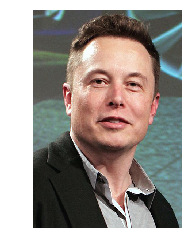

In [376]:
face_img_path = next(iter(files.upload()))
face_img = PIL.Image.open(face_img_path)
plt.imshow(face_img)
plt.axis('off')

Ďalej si tvár mierne predspracujeme. Extrahujeme kľúčové body a obrázok tváre podľa nich zarovnáme na určité preddefinované pozície.

(-0.5, 1023.5, 1023.5, -0.5)

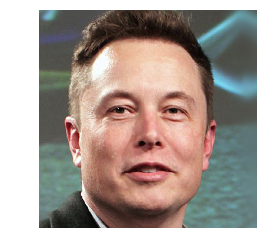

In [377]:
face_landmarks = next(landmarks_detector.get_landmarks(np.asarray(face_img)))
aligned_img = image_align(face_img, face_landmarks, output_size=aligned_img_size)
plt.imshow(aligned_img)
plt.axis('off')

Začneme optimalizáciu z nulového latentného vektora pomocou metódy LBFGS:

In [0]:
evaluator = Evaluator(aligned_img, loss_grad_func, dlatent_shape)
latent_init = np.zeros(latent_shape)
dlatent = map_func([latent_init])[0]

In [379]:
dlatent, min_val, info = fmin_l_bfgs_b(evaluator.loss, dlatent.flatten(),
     fprime=evaluator.grads, maxfun=400, disp=1)

eval 1, loss 3.3524625301361084
eval 2, loss 2.554772138595581
eval 3, loss 2.0897369384765625
eval 4, loss 2.024355173110962
eval 5, loss 1.9373809099197388
eval 6, loss 1.8993520736694336
eval 7, loss 1.8810542821884155
eval 8, loss 1.861640214920044
eval 9, loss 1.8253412246704102
eval 10, loss 1.7488878965377808
eval 11, loss 2.214826822280884
eval 12, loss 1.7568305730819702
eval 13, loss 1.7319610118865967
eval 14, loss 1.6862338781356812
eval 15, loss 1.6153806447982788
eval 16, loss 1.5662013292312622
eval 17, loss 1.6939185857772827
eval 18, loss 1.4898266792297363
eval 19, loss 1.3978943824768066
eval 20, loss 1.4228551387786865
eval 21, loss 1.3297789096832275
eval 22, loss 1.3842220306396484
eval 23, loss 1.3151028156280518
eval 24, loss 1.2965108156204224
eval 25, loss 1.2651840448379517
eval 26, loss 1.2524675130844116
eval 27, loss 1.239723563194275
eval 28, loss 1.2263262271881104
eval 29, loss 1.2126487493515015
eval 30, loss 1.1945970058441162
eval 31, loss 1.20448875

### Generovanie obrázka

Po minimalizácii chybovej funkcie získame štýlový latentný vektor, ktorý približne zodpovedá pôvodnému obrázku. Keď na základe neho vygenerujeme novú tvár, mala by sa podobať pôvodnej tvári.

(-0.5, 1023.5, 1023.5, -0.5)

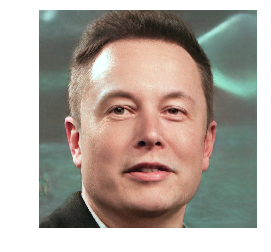

In [380]:
img = gen_func([dlatent.reshape((dlatent_shape))])[0][0]
plt.imshow(img)
plt.axis('off')

## Manipulácia latentného vektora

Latentný vektor fotografie je možné ďalej modifikovať. Podobne ako pri rôznych iných typoch GAN a embedovaní, niektoré aritmetické operácie s vektormi nesú sémantický význam. Je napríklad možné identifikovať vektor, ktorý približne zodpovedá úsmevu, veku, pohlaviu a pod. Niekoľko takýchto vektorov si načítame:

In [0]:
smile_direction = np.load('stylegan-encoder/ffhq_dataset/latent_directions/smile.npy')
gender_direction = np.load('stylegan-encoder/ffhq_dataset/latent_directions/gender.npy')
age_direction = np.load('stylegan-encoder/ffhq_dataset/latent_directions/age.npy')

Aplikácia úsmevu:

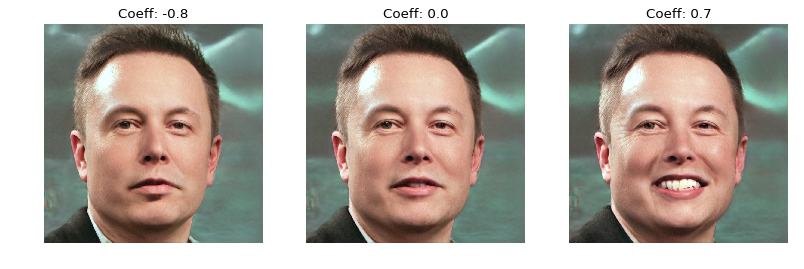

In [382]:
move_and_show(dlatent.reshape((dlatent_shape)), smile_direction, [-0.8, 0, 0.7])

Zmena pohlavia:

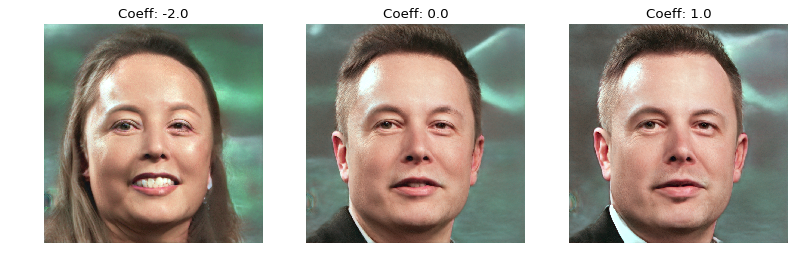

In [383]:
move_and_show(dlatent.reshape((dlatent_shape)), gender_direction, [-2, 0, 1])

Zmena veku:

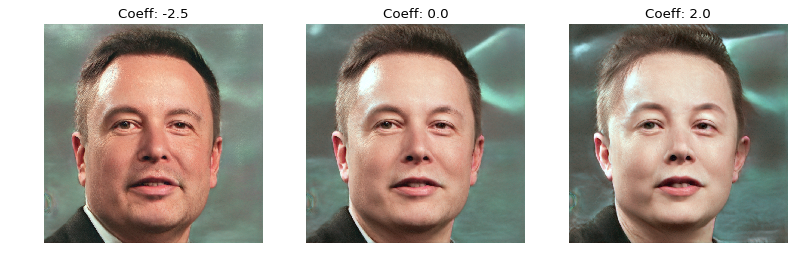

In [398]:
move_and_show(dlatent.reshape((dlatent_shape)), age_direction, [-2.5, 0, 2])

## Zmiešavanie štýlov

Alternatívne vieme zmiešať štýly z viacerých obrázkov.

(-0.5, 1023.5, 1023.5, -0.5)

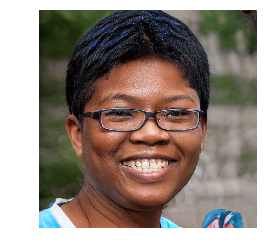

In [399]:
latent2 = np.random.RandomState(1898).randn(*latent_shape)
dlatent2 = map_func([latent2])[0]
img2 = gen_func([dlatent2])[0][0]
plt.imshow(img2)
plt.axis('off')

In [0]:
style_range = [0, 1, 2, 3, 4, 5, 8, 9, 10]
dlatent3 = dlatent2.copy()
dlatent3[:, style_range] = dlatent.reshape(dlatent_shape)[:, style_range]

(-0.5, 1023.5, 1023.5, -0.5)

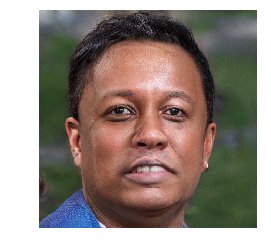

In [401]:
img2 = gen_func([dlatent3])[0][0]
plt.imshow(img2)
plt.axis('off')

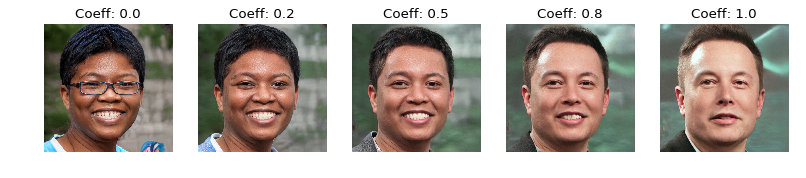

In [402]:
blend_and_show(dlatent.reshape(dlatent_shape), dlatent2, [0, 0.25, 0.5, 0.75, 1])

## Aritmetika

In [0]:
def find_mean_dlatent(seeds):
    mean_dlatent = np.zeros(dlatent_shape)
    
    for s in seeds:
        h_latent = np.random.RandomState(s).randn(*latent_shape)
        h_dlatent = map_func([h_latent])[0]

        mean_dlatent += h_dlatent / len(seeds)
        
    return mean_dlatent

In [0]:
female_long_hair = [517, 519, 521, 523, 525, 528, 529, 538, 539, 540, 618, 642, 655]
female_short_hair = [537, 546, 561, 597, 599, 602, 610, 616, 627, 637, 652]

In [0]:
male_short_hair = [535, 536, 549, 558, 559, 560]
male_long_hair = [629]

In [0]:
long_hair_dlatent = find_mean_dlatent(female_long_hair)
short_hair_dlatent = find_mean_dlatent(female_short_hair)

(-0.5, 1023.5, 1023.5, -0.5)

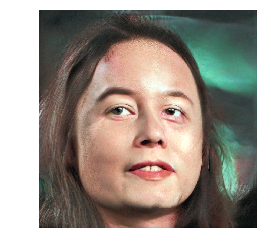

In [427]:
dlatent2 = dlatent.reshape(dlatent_shape) + 0.8 * (long_hair_dlatent - short_hair_dlatent)
img2 = gen_func([dlatent2])[0][0]
plt.imshow(img2)
plt.axis('off')